In [1]:
# All Imports
from collections import Counter
from operator import itemgetter
import ConfigParser
import matplotlib.pyplot as plt
import networkx as nx
import sys
import time
import io
import os
import re
import nltk
import string
import shutil
import hashlib
from sklearn.cross_validation import KFold
from sklearn import cross_validation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
#nltk.download()
from tabulate import tabulate
from nltk.corpus import sentiwordnet
from nltk.corpus import SentiWordNetCorpusReader, SentiSynset
import pylab as plt
import numpy as np
import scipy.stats as stats
import pylab as pl
%matplotlib inline
swn_root = './'
swn_filename = 'SentiWordNet_3.0.0_20130122.txt'
swn = SentiWordNetCorpusReader(swn_root,swn_filename,encoding='utf-8')

In [2]:
# Converts a file to list of strings where each item is one line of the file.
def file2string(filename):
    result = []
    result = io.open(filename, encoding='utf8').readlines()
    for val in range(0,len(result)):
        result[val]=re.sub("\n","",result[val])        
    return result

In [3]:
#Create a dictionary with product id as key and item title and manufacturer tuple as value taking a file as input
def productsDictionary(productsfile):
    productlst = file2string(productsfile)
    result = {}
    for product in productlst:
        temp = product.split("\t")
        result[temp[0]]=(temp[1],temp[2])
    return result

product_dictionary = productsDictionary("items.txt")
print "Created product dictionary with",len(product_dictionary.keys()),"products"

Created product dictionary with 40 products


In [4]:
## To calculate the Sentiment score of a review. 


def calculateSynsetScore(review):
    tokens = nltk.word_tokenize(review)
    score = 0
    for t in tokens:
        try:
            synset = swn.senti_synsets(t)[0]
            #print t,"\t",synset
            score = score + synset.pos_score() - synset.neg_score()
        except(IndexError):
            #print "Index error at:", t
            pass
    return score

In [5]:
# preprocess the review data


# URLs
reg_URL = re.compile(r"http\S+")

# Spliting by word boundaries
reg_Wordbound = re.compile(r"\W+")

# Replace Repeating words like gooooooooood 

reg_Repeat = re.compile(r"(.)\1{1,}", re.IGNORECASE);

def replace_repeat(match):
    return match.group(1)+match.group(1)

# Emoticons
#replacing emoticons, you can specify any name

emoticons = [('', [':-)', ':)', '(:', '(-:', ':-D', ':D', 'X-D', 'XD', 'xD', '<3', ':\*', ';-)', ';)', ';-D', ';D', '(;', '(-;', ':-(', ':(', '(:', '(-:', ':,(', ':\'(', ':"(', ':(('] )]


punct_list = []

for i in string.punctuation:
    punct_list.append(i)
    
# Punctuations
punctuations = \
    [   #Classify all punctuation as same
        #you can control which punctuation to use by creating new punctuation list
        #i have stripped down all the punctuations, you can put something in that blank
        ('',punct_list ),\
    ]


#For emoticon regexes

def escape_paren(arr):
    return [review.replace(')', '[)}\]]').replace('(', '[({\[]') for review in arr]

def reg_Union(arr):
    return '(' + '|'.join( arr ) + ')'

reg_Emoticons = [ (repl, re.compile(reg_Union(escape_paren(regx))) ) \
                    for (repl, regx) in emoticons ]


#For punctuation replacement
def replace_punctuations(match):
    review = match.group(0)
    repl = []
    for (key, parr) in punctuations :
        for punc in parr :
            if punc in review:
                repl.append(key)
    if( len(repl)>0 ) :
        return ' ' + ' '.join(repl) + ' '
    else :
        return ' '


def preprocess_Urls(review, subject='', query=[]):
    return re.sub( regURL, '', review )

def preprocess_Emoticons(review, subject='', query=[]):
    for (repl, regx) in regEmoticons :
        review = re.sub(regx, ' '+repl+' ', review)
    return review

def preprocess_Punctuations(review, subject='', query=[]):
    return re.sub( reg_Wordbound , replace_punctuations, review )

def preprocess_Repeatings(review, subject='', query=[]):
    return re.sub( reg_Repeat, replace_repeat, review )


def processAll(review, subject='', query=[]):

    if(len(query)>0):
        query_regex = "|".join([ re.escape(q) for q in query])
        review = re.sub(query_regex, '', review, flags=re.IGNORECASE )
    
    review = re.sub( reg_URL, '', review )
    

    for (repl, regx) in reg_Emoticons :
        review = re.sub(regx, ' '+repl+' ', review)


    review = review.replace('\'',' ')

    #replcae underscore with space
    review = review.replace('_',' ')
    

    review = re.sub( reg_Wordbound , replace_punctuations, review )
    review = re.sub( reg_Repeat, replace_repeat, review )
    
    lst = review.lower().split()
    
    
    return ' '.join(lst)

In [6]:
#Replace the word which contains n't i.e wouldn't,shouldn't  
#   with  would not, should not and return the string.   

def replace_with_not(string):
    ns = ""
    suffix = "n't"
    word = "not"
    for stn in string.split():
        if stn.endswith(suffix):
            stn = stn[:-3]
            ns += stn + ' ' + word + ' '
        else:
            ns += stn + ' '
    return ns
    
replace_with_not("this wouldn't be replaced.")

'this would not be replaced. '

In [7]:
# Reads a file named (productID).txt and returns a list of all reviews present in that file for the given productID
def getAllReviews(productID):
    reviews = file2string("Reviews_Data/"+ productID+".txt") 
    result = []
    for review_line in reviews:
        #print review.split("->")[1],"\n"
        review = review_line.split("->")[1]
        r1 = processAll(review)
        review = replace_with_not(r1)
        score = calculateSynsetScore(review)
        result.append((review,score))
    return result

In [8]:
#Create a dictionary with product id as key and list of its reviews as value.

product_ids = product_dictionary.keys()
product_reviews = {}

for id in product_ids:
    reviews = getAllReviews(id)
    product_reviews[id]=reviews;
    print "Reading reviews for Product ID:",id,"\tNumber of total reviews:",len(reviews)

cnt = Counter()
for key in product_reviews.keys():
    #print "Product ID:",key,"\tNumber of reviews:",len(product_reviews[key])
    cnt[len(product_reviews[key])]+=1
print "\n",cnt

Reading reviews for Product ID: B004KZJ0UM 	Number of total reviews: 316
Reading reviews for Product ID: B00ZOO1RFO 	Number of total reviews: 76
Reading reviews for Product ID: B00K6ZIL0K 	Number of total reviews: 22
Reading reviews for Product ID: B00PGELA04 	Number of total reviews: 46
Reading reviews for Product ID: B00SV72ZA2 	Number of total reviews: 70
Reading reviews for Product ID: B00HRO37UC 	Number of total reviews: 53
Reading reviews for Product ID: B011KFQASE 	Number of total reviews: 100
Reading reviews for Product ID: B00PPTP9IO 	Number of total reviews: 92
Reading reviews for Product ID: B00Z1R85O0 	Number of total reviews: 15
Reading reviews for Product ID: B00VGNZ4PG 	Number of total reviews: 50
Reading reviews for Product ID: B00THEP15O 	Number of total reviews: 55
Reading reviews for Product ID: B01606KJ6C 	Number of total reviews: 49
Reading reviews for Product ID: B015PYZXRU 	Number of total reviews: 39
Reading reviews for Product ID: B00VKL0I96 	Number of total re

In [60]:
#Calculates average sentiment of all reviews that a product received.
def productAverageScore(reviews_dict):
    result = []
    for pid in reviews_dict.keys():
        reviews_lst = reviews_dict[pid]
        sum = 0
        for review in reviews_lst:
            sum+=review[1]
        
        avg = sum/len(reviews_lst)
        result.append((pid,avg))
        result = sorted(result,key = itemgetter(1),reverse = True)
    
    return result
        
product_avg = productAverageScore(product_reviews)
#print product_avg[0][1]

cnt = 0
table = []
for val in range(len(product_avg)):
    cnt+=1
    table.append([cnt,product_dictionary[product_avg[val][0]][0],product_avg[val][1]])
    
print tabulate(table,headers=["Item Number","Product Title","Sentiment Score"], tablefmt="simple", numalign="center")


 Item Number   Product Title                                                        Sentiment Score
-------------  ------------------------------------------------------------------  -----------------
      1        Microsoft Surface 2 (32 GB)                                              1.94442
      2        Dell Inspiron i7359-6790SLV 2-in-1 Touchscreen Laptop                    1.74788
      3        G-Tab Iota Quad Core Android Tablet PC                                   1.45588
      4        2015 Newest Dell Chromebook, 11.6 inch HD Non-Touch LCD                   1.25
      5        Microsoft Surface Pro 4, Intel Core i5                                   1.23724
      6        Dell Inspiron 3000 15.6-Inches Windows 8.1 Laptop                        1.05556
      7        Microsoft Surface 3 Tablet                                                0.94
      8        Dell 15 5000 i15547-5003sLV 16-Inch Touch Screen Laptop                 0.923913
      9        ASUS F555LA-AB31 15.

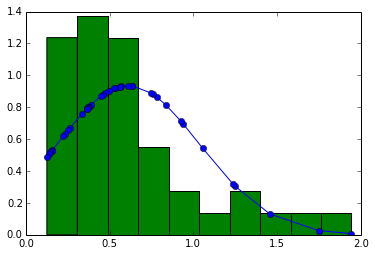

In [10]:
## Histogram of Product Average rating. 

h = []
for i in range(len(product_avg)):
    h.append(product_avg[i][1])

#h = sorted(h)
#print mp.mean(h)   
fit = stats.norm.pdf(h, np.mean(h), np.std(h))  #this is a fitting indeed

pl.plot(h,fit,'-o')

pl.hist(h,normed=True)      #use this to draw histogram of your data

pl.show()

In [11]:
#Calculates average sentiment of all reviews that a product received.
def productFeatureScore(reviews_dict,feature):
    result = []
    for pid in reviews_dict.keys():
        reviews_lst = reviews_dict[pid]
        sum = 0.0
        cnt = 0.0
        for review in reviews_lst:
            reviewstr = review[0].lower()
            if re.findall(feature, reviewstr):
                sum+=review[1]
                cnt+=1
        if cnt != 0:
            avg = sum/cnt
            result.append((pid,avg))
        result = sorted(result,key = itemgetter(1),reverse = True)
    return result

In [62]:
#Searching for products with reviews related to touch
product_touch = productFeatureScore(product_reviews,"touch")

cnt = 0
table = []
for val in range(len(product_touch)):
    cnt+=1
    table.append([cnt,product_dictionary[product_touch[val][0]][0],product_touch[val][1]])
print tabulate(table,headers=["Item Number","Product Title","Sentiment Score"], tablefmt="simple", numalign="center")

 Item Number   Product Title                                                        Sentiment Score
-------------  ------------------------------------------------------------------  -----------------
      1        Microsoft Surface 2 (32 GB)                                              5.29421
      2        Acer Aspire Switch 10 E SW3-013-1566 2-in-1 Tablet & Laptop               4.25
      3        Dell Inspiron i7359-6790SLV 2-in-1 Touchscreen Laptop                    3.40217
      4        Dell Inspiron i3000-5099SLV Touchscreen Laptop                            3.375
      5        Microsoft Surface Pro 4, Intel Core i5                                   2.41667
      6        Dell Inspiron 15 i5548-4167SLV - 15.6" Touchscreen                       2.33333
      7        G-Tab Iota Quad Core Android Tablet PC                                     2.2
      8        Dell Inspiron 15 7000 Series i7537T Touchscreen Laptop                   1.96685
      9        Microsoft Surface 3 T

In [58]:
#Searching for products with reviews related to processor
product_processor = productFeatureScore(product_reviews,"processor")

cnt = 0
table = []
for val in range(len(product_processor)):
    cnt+=1
    table.append([cnt,product_dictionary[product_processor[val][0]][0],product_processor[val][1]])
print tabulate(table,headers=["Item Number","Product Title","Sentiment Score"], tablefmt="simple", numalign="center")

 Item Number   Product Title                                                        Sentiment Score
-------------  ------------------------------------------------------------------  -----------------
      1        Microsoft Surface 2 (32 GB)                                               9.625
      2        Dell Latitude E6420 Premium 14.1-Inch Business Laptop                     6.125
      3        Dell - Inspiron I3542-11001BK 15.6" Touch-Screen Laptop                   5.125
      4        Dell Inspiron i7359-6790SLV 2-in-1 Touchscreen Laptop                     5.025
      5        Toshiba Radius 2-in-1 11.6" Touch-screen Laptop                          4.5625
      6        Dell Inspiron 15 i5548-4167SLV - 15.6" Touchscreen                         3.5
      7        ASUS F555LA-AB31 15.6-inch Full-HD Laptop                                2.40687
      8        Dell Latitude D630 14.1-Inch Notebook PC - Silver 2011 Model             2.34683
      9        Dell Inspiron i5748-214

In [59]:
#Searching for products with reviews related to processor
product_storage = productFeatureScore(product_reviews,"storage")

cnt =0
table = []
for val in range(len(product_storage)):
    cnt+=1
    table.append([cnt,product_dictionary[product_storage[val][0]][0],product_storage[val][1]])
print tabulate(table,headers=["Item Number","Product Title","Sentiment Score"], tablefmt="simple", numalign="center")
    

 Item Number   Product Title                                                 Sentiment Score
-------------  -----------------------------------------------------------  -----------------
      1        Microsoft Surface 2 (32 GB)                                       5.36538
      2        Dell Inspiron 15.6-Inch Touchscreen Laptop (i15RVT-6195BLK)        4.25
      3        Dell Inspiron i3531-1200BK 16-Inch Laptop,Black                    4.25
      4        G-Tab Iota Quad Core Android Tablet PC                               3
      5        Dell Inspiron i5748-2143sLV 17.3-Inch Laptop                       1.875
      6        2015 Newest Model DELL Inspiron 15 Touchscreen Laptop              1.875
      7        Dell Inspiron 11 3000 Series 2-in-1  11.6 Inch Laptop              1.625
      8        Dell Inspiron 15 i5548-1670SLV Touchscreen Laptop                  1.125
      9        Dell - Inspiron I3542-11001BK 15.6" Touch-Screen Laptop            1.125
     10        2015 Newe

In [15]:
#Create Graph for Every method. 

def Create_Graph(var):
    x = []
    y = []
    p = []
    for i in range(len(var)):
        p.append(i+1)
        #print p
        x.append(product_dictionary[var[i][0]][0])            
        y.append(var[i][1])
    plt.bar(p,y,align='center')
    #plt.figure(figsize=(1,1))
    plt.xticks(p)
    plt.xlabel('Products')
    plt.ylabel('Average Ratings')
    plt.show()
    table = []
    cnt = 0
    for i in x:
        cnt+=1
        table.append([cnt,i])
    print tabulate(table,headers=["Item Number","Product ID"], tablefmt="grid", numalign="center")

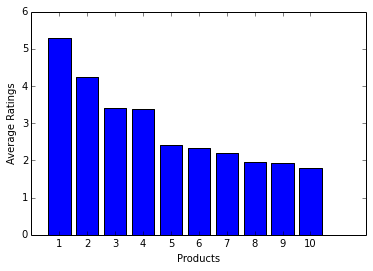

+---------------+-------------------------------------------------------------+
|  Item Number  | Product ID                                                  |
+===============+=============================================================+
|       1       | Microsoft Surface 2 (32 GB)                                 |
+---------------+-------------------------------------------------------------+
|       2       | Acer Aspire Switch 10 E SW3-013-1566 2-in-1 Tablet & Laptop |
+---------------+-------------------------------------------------------------+
|       3       | Dell Inspiron i7359-6790SLV 2-in-1 Touchscreen Laptop       |
+---------------+-------------------------------------------------------------+
|       4       | Dell Inspiron i3000-5099SLV Touchscreen Laptop              |
+---------------+-------------------------------------------------------------+
|       5       | Microsoft Surface Pro 4, Intel Core i5                      |
+---------------+-----------------------

In [16]:
## Create a graph of top 10 best 'Touch' feature laptop. 


Create_Graph(product_touch[:10])

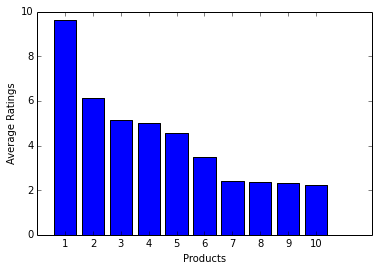

+---------------+--------------------------------------------------------------+
|  Item Number  | Product ID                                                   |
+===============+==============================================================+
|       1       | Microsoft Surface 2 (32 GB)                                  |
+---------------+--------------------------------------------------------------+
|       2       | Dell Latitude E6420 Premium 14.1-Inch Business Laptop        |
+---------------+--------------------------------------------------------------+
|       3       | Dell - Inspiron I3542-11001BK 15.6" Touch-Screen Laptop      |
+---------------+--------------------------------------------------------------+
|       4       | Dell Inspiron i7359-6790SLV 2-in-1 Touchscreen Laptop        |
+---------------+--------------------------------------------------------------+
|       5       | Toshiba Radius 2-in-1 11.6" Touch-screen Laptop              |
+---------------+-----------

In [17]:
## Create a graph of top 10 best 'Processor' feature laptop. 


Create_Graph(product_processor[:10])

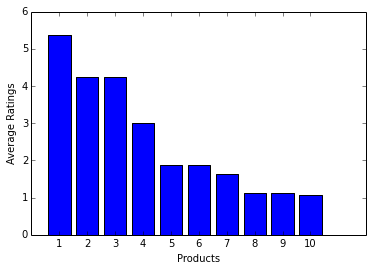

+---------------+-------------------------------------------------------------+
|  Item Number  | Product ID                                                  |
+===============+=============================================================+
|       1       | Microsoft Surface 2 (32 GB)                                 |
+---------------+-------------------------------------------------------------+
|       2       | Dell Inspiron 15.6-Inch Touchscreen Laptop (i15RVT-6195BLK) |
+---------------+-------------------------------------------------------------+
|       3       | Dell Inspiron i3531-1200BK 16-Inch Laptop,Black             |
+---------------+-------------------------------------------------------------+
|       4       | G-Tab Iota Quad Core Android Tablet PC                      |
+---------------+-------------------------------------------------------------+
|       5       | Dell Inspiron i5748-2143sLV 17.3-Inch Laptop                |
+---------------+-----------------------

In [18]:
## Create a graph of top 10 best 'Storage' feature laptop. 


Create_Graph(product_storage[:10])

In [19]:
## Storing one by one processed review in result set. So result set has all the reviews. 


result = []
for i in product_ids:
    reviews = file2string("Reviews_Data/"+ i +".txt")
    for review_line in reviews:
        review = review_line.split("->")[1]
        r1 = processAll(review)
        
        result.append(review)
        
print "Total number of Reviews collected are %d." %len(result)

Total number of Reviews collected are 2829.


In [ ]:
######     Do not run this code   #########
## I have already done this and store all the reviews in Data Folder. This will make a different file for each 
##  review and store in Data Folder. 

i = 1
rslt = []
for review in result:
    #print review
    score = calculateSynsetScore(review)
    rslt.append((review,score))
    f = open('Data/r'+ str(i) +'.txt','w+')
    f.write(review)
    f.close()
    i += 1

In [20]:
# Here is the path to the data directory.

path = 'Data'
print('subdirectories are:' + str(os.listdir(path)))

subdirectories are:['test', 'train']


In [21]:
## To get the list of files on specific path. 

def get_files(path):
    list = []
    #get list of files in geiven directory
    for a in sorted(os.listdir(path)):
        #append all files path to list
        list.append(path + os.sep + a)
    return list

In [22]:
files = get_files('Data/train/pos')

In [ ]:
######     Do not run this code   #########
## This script is for distinguishing reviews based on it's sentiment score. if sentiment score > 0 then put it in pos folder
##      else move into neg folder. DO this procedure separately for train and test data both.  

pos = []
neg = []

dest1 = 'Data/train/pos'        ## or 'Data/test/pos'
dest2 = 'Data/train/neg'        ## or 'Data/train/neg'

for file in files:
    f = open(file,'r+')
    m = processAll(f.read())
    review = replace_with_not(m)
    score = calculateSynsetScore(review)
    if score > 0:
        #pos.append(m)
        shutil.move(file, dest1)
    else:
        #neg.append(m)
        shutil.move(file, dest2)
    
        
    f.close()

    f = open(file,'wb')
    f.write(str(review))
    f.close()

In [23]:
pos_train_files = get_files(path + os.sep + 'train' + os.sep + 'pos')
neg_train_files = get_files(path + os.sep + 'train' + os.sep + 'neg')
all_train_files = pos_train_files + neg_train_files

print('found %d positive and %d negative training files' %
      (len(pos_train_files), len(neg_train_files)))
print('first positive file: %s' % pos_train_files[0])
print('first negative file: %s' % neg_train_files[0])

found 1103 positive and 1093 negative training files
first positive file: Data/train/pos/r1.txt
first negative file: Data/train/neg/r10.txt


In [24]:
def get_true_labels(file_names):
    """Return a *numpy array* of ints for the true sentiment labels of each file.
    1 means positive, 0 means negative. Use the name of the file to determine
    the true label.
    Params:
        file_names....a list of .txt file paths, e.g., Data/train/pos/r1.txt
    Returns:
        a numpy array of 1 or 0 values corresponding to each element
        of file_names, where 1 indicates a positive review, and 0
        indicates a negative review.
    """
    ###TODO
    ###
    labels =[]
    for f in file_names:
        if 'pos' in f:
            labels.append(1)
        elif 'neg' in f:
            labels.append(0)
    lst = np.array(labels)
    return lst

labels = get_true_labels(all_train_files)
print('first 3 and last 3 labels are: %s' % str(labels[[1,2,3,-3,-2,-1]]))

first 3 and last 3 labels are: [1 1 1 0 0 0]


In [25]:
#let's look randomly how does a Posotive and negative review look like

f = open(pos_train_files[3],'r')
print "Positive Product Review: ", f.read(), "\n"
f.close()

f = open(neg_train_files[0],'r')
print "Negative Product Review: ", f.read(), "\n"
f.close()

Positive Product Review:  just exactly what i wanted and would recommend to anyone looking for a great personal computer for everyday use very satisfied 

Negative Product Review:  it s disappointing how limited this version of the surface is my daughter cannot use many online textbooks or watch videos for school because the microsoft 8 rt os doesn t allow installation of the necessary plugins or software 



In [26]:
def tokenize(text):
    """Given a string, return a list of tokens such that: (1) all
    tokens are lowercase, (2) all punctuation is removed. Note that
    underscore (_) is not considered punctuation.
    Params:
        text....a string
    Returns:
        a list of tokens
    """
    """regex = re.compile('[%s]' % re.escape(string.punctuation))
    text = regex.sub('\P{P}_','',text)
    #text = regex.sub(\P{P}_+,"", text)
    #text = text.translate(string.maketrans("",""), string.punctuation)
    #preg_replace('/^[^\P{P}_-]+|[^\P{P}_-]+$/u', '', text)
    print text   """
    
    return re.sub('\W', ' ', text).lower().split()

In [27]:
def do_vectorize_including_stop_words(filenames, tokenizer_fn=tokenize, min_df=1,
                 max_df=1., binary=True, ngram_range=(1,1)):
    """
    Convert a list of filenames into a sparse csr_matrix, where
    each row is a file and each column represents a unique word.
    Use sklearn's CountVectorizer: http://goo.gl/eJ2PJ5
    Params:
        filenames.......list of review file names
        tokenizer_fn....the function used to tokenize each document
        min_df..........remove terms from the vocabulary that don't appear
                        in at least this many documents
        max_df..........remove terms from the vocabulary that appear in more
                        than this fraction of documents
        binary..........If true, each documents is represented by a binary
                        vector, where 1 means a term occurs at least once in 
                        the document. If false, the term frequency is used instead.
        ngram_range.....A tuple (n,m) means to use phrases of length n to m inclusive.
                        E.g., (1,2) means consider unigrams and bigrams.
    Return:
        A tuple (X, vec), where X is the csr_matrix of feature vectors,
        and vec is the CountVectorizer object.
    """
    ###TODO
    ###
    
    
    vec = CountVectorizer(input = 'filename', tokenizer = tokenizer_fn,
                         min_df = min_df, max_df = max_df, binary = binary, ngram_range = ngram_range,dtype=int)    
    X=vec.fit_transform(filenames)
    return (X,vec)

    
matrix_stop, vec_stop = do_vectorize_including_stop_words(all_train_files)
print ('Including Common Stop Words Matrix represents %d Documents with %d Features ' % (matrix_stop.shape[0], matrix_stop.shape[1]))
print
print('first document has terms:\n%s' % (str(sorted(matrix_stop[1].nonzero()[1]))))

Including Common Stop Words Matrix represents 2196 Documents with 7689 Features 

first document has terms:
[6, 28, 93, 164, 203, 235, 282, 323, 356, 505, 528, 547, 577, 578, 584, 590, 595, 612, 615, 663, 678, 694, 702, 727, 753, 808, 823, 881, 922, 931, 959, 972, 1022, 1174, 1188, 1216, 1222, 1244, 1409, 1488, 1495, 1632, 1728, 1731, 1757, 1818, 1867, 1886, 1889, 1906, 1991, 2021, 2039, 2157, 2167, 2169, 2173, 2181, 2236, 2293, 2295, 2324, 2345, 2461, 2463, 2465, 2474, 2486, 2492, 2504, 2548, 2557, 2584, 2674, 2694, 2726, 2729, 2790, 2824, 2836, 2870, 2886, 2912, 2929, 2935, 2975, 3006, 3028, 3032, 3050, 3061, 3102, 3151, 3201, 3213, 3368, 3376, 3402, 3433, 3483, 3576, 3589, 3591, 3612, 3645, 3680, 3695, 3702, 3707, 3712, 3768, 3784, 3839, 3919, 3945, 3983, 4006, 4039, 4040, 4045, 4060, 4065, 4153, 4156, 4165, 4184, 4230, 4244, 4292, 4300, 4318, 4343, 4395, 4401, 4413, 4424, 4439, 4445, 4476, 4490, 4496, 4556, 4571, 4573, 4653, 4662, 4678, 4681, 4722, 4732, 4737, 4738, 4746, 4762, 490

In [28]:
##  Get the Common stop words in English 
##  https://github.com/Alir3z4/python-stop-words


from stop_words import get_stop_words

stop_words = get_stop_words('english')
print stop_words
print

print ("There are total %d stop words in English" % len(stop_words))

[u'a', u'about', u'above', u'after', u'again', u'against', u'all', u'am', u'an', u'and', u'any', u'are', u"aren't", u'as', u'at', u'be', u'because', u'been', u'before', u'being', u'below', u'between', u'both', u'but', u'by', u"can't", u'cannot', u'could', u"couldn't", u'did', u"didn't", u'do', u'does', u"doesn't", u'doing', u"don't", u'down', u'during', u'each', u'few', u'for', u'from', u'further', u'had', u"hadn't", u'has', u"hasn't", u'have', u"haven't", u'having', u'he', u"he'd", u"he'll", u"he's", u'her', u'here', u"here's", u'hers', u'herself', u'him', u'himself', u'his', u'how', u"how's", u'i', u"i'd", u"i'll", u"i'm", u"i've", u'if', u'in', u'into', u'is', u"isn't", u'it', u"it's", u'its', u'itself', u"let's", u'me', u'more', u'most', u"mustn't", u'my', u'myself', u'no', u'nor', u'not', u'of', u'off', u'on', u'once', u'only', u'or', u'other', u'ought', u'our', u'ours', u'ourselves', u'out', u'over', u'own', u'same', u"shan't", u'she', u"she'd", u"she'll", u"she's", u'should', u"

In [29]:
## Find how many words are there in our feature matrix

cnt = len(set(vec_stop.get_feature_names()).intersection(stop_words))
print "Our feature vector has %d stop words" % (cnt)

Our feature vector has 120 stop words


In [30]:
def do_vectorize(filenames, tokenizer_fn=tokenize, min_df=1,
                 max_df=1., binary=True, ngram_range=(1,1)):
    
    """
    Convert a list of filenames into a sparse csr_matrix, where
    each row is a file and each column represents a unique word.
    Use sklearn's CountVectorizer: http://goo.gl/eJ2PJ5
    Params:
        filenames.......list of review file names
        tokenizer_fn....the function used to tokenize each document
        min_df..........remove terms from the vocabulary that don't appear
                        in at least this many documents
        max_df..........remove terms from the vocabulary that appear in more
                        than this fraction of documents
        binary..........If true, each documents is represented by a binary
                        vector, where 1 means a term occurs at least once in 
                        the document. If false, the term frequency is used instead.
        ngram_range.....A tuple (n,m) means to use phrases of length n to m inclusive.
                        E.g., (1,2) means consider unigrams and bigrams.
    Return:
        A tuple (X, vec), where X is the csr_matrix of feature vectors,
        and vec is the CountVectorizer object.
    """
    ###TODO
    ###
    
    vec = CountVectorizer(input='filename', tokenizer=tokenizer_fn, min_df=min_df,
                 max_df=max_df, binary=binary, ngram_range=ngram_range, stop_words = 'english', dtype=int)
    
    X = vec.fit_transform(filenames)   
    return (X,vec)
    
matrix, vec = do_vectorize(all_train_files)
print ('matrix represents %d documents with %d features excluding stop words' % (matrix.shape[0], matrix.shape[1]))
print 
print('first document has terms:\n%s' % ((sorted(matrix[1].nonzero()[1]))))

matrix represents 2196 documents with 7409 features excluding stop words

first document has terms:
[6, 28, 93, 164, 203, 235, 282, 323, 501, 539, 636, 651, 667, 777, 791, 887, 911, 923, 973, 1162, 1187, 1352, 1431, 1438, 1574, 1668, 1671, 1697, 1757, 1806, 1825, 1828, 1845, 1929, 1958, 1976, 2103, 2105, 2109, 2117, 2170, 2224, 2226, 2255, 2274, 2386, 2404, 2410, 2421, 2465, 2474, 2501, 2591, 2642, 2700, 2734, 2791, 2837, 2876, 2927, 2931, 2959, 3000, 3261, 3455, 3468, 3470, 3491, 3523, 3557, 3578, 3641, 3656, 3711, 3788, 3813, 3851, 3874, 3907, 3908, 3913, 3928, 3933, 4020, 4023, 4032, 4107, 4155, 4163, 4180, 4204, 4258, 4269, 4294, 4326, 4340, 4346, 4399, 4413, 4497, 4560, 4583, 4726, 4864, 4871, 4893, 4909, 4923, 4943, 5016, 5023, 5033, 5126, 5127, 5246, 5257, 5296, 5502, 5562, 5632, 5643, 5667, 5675, 5690, 5703, 5758, 5763, 5893, 5930, 5942, 5982, 6035, 6147, 6160, 6185, 6202, 6229, 6248, 6281, 6282, 6337, 6338, 6424, 6441, 6478, 6523, 6533, 6564, 6611, 6654, 6689, 6839, 6842, 6966

In [31]:
def tokenize_with_not(text):
    """Does the same thing as tokenize_with_punct, with the following difference:
    whenever the term 'not' appears, change the two subsequent tokens to have the prefix
    'not_' prior to the token. See the example below. You may call 
    tokenize_with_punct as a subroutine.
    Params:
        text....a string
    Returns:
        a list of tokens
    """
    ###TODO
    ###
    not_tokens = tokenize(text)
    i=0
    while (i<len(not_tokens)):
        if not_tokens[i] == 'not':
            if i < len(not_tokens)-2:
                not_tokens[i+1] = "not_" + not_tokens[i+1]
                not_tokens[i+2] = "not_" + not_tokens[i+2]
                i+=2
                
            elif i< len(not_tokens)-1:
                not_tokens[i+1] ="not_"+ not_tokens[i+1]
                i+=1
                
        i+=1
        
    return not_tokens

In [32]:
# Do not modify. This is to randomize the order of the documents, but
# in a way that is consistent across platforms.
# See: http://stackoverflow.com/a/18992474/1756896
# You should run this block once to get the shuffled data.
def repeatable_random(seed):
    hash = str(seed)
    while True:
        hash = hashlib.md5(hash).digest()
        for c in hash:
            yield ord(c)

def repeatable_shuffle(X, y, filenames):
    r = repeatable_random(42) 
    indices = sorted(range(X.shape[0]), key=lambda x: next(r))
    return X[indices], y[indices], np.array(filenames)[indices]

X, y, filenames = repeatable_shuffle(matrix, labels, all_train_files)

print('first shuffled document %s has label %d and terms: %s' % 
      (filenames[0], y[0], sorted(X[0].nonzero()[1])))

first shuffled document Data/train/pos/r1181.txt has label 1 and terms: [71, 1415, 1459, 1874, 1910, 1929, 2229, 2404, 2417, 2552, 2566, 2941, 2958, 3210, 3581, 3732, 3900, 4508, 4552, 4871, 5056, 5650, 5839, 6095, 6611, 6966, 7001, 7012, 7313, 7315, 7375]


In [ ]:
# Naive Bayes Classifier
#  http://scikit-learn.org/stable/modules/naive_bayes.html

In [33]:
from sklearn.naive_bayes import MultinomialNB

def get_clf_naive():
    return MultinomialNB(alpha = 0.1)

In [34]:
def do_cross_validation(X, y, n_folds=5, verbose=False):
    """
    Perform n-fold cross validation, calling get_clf() to train n
    different classifiers. Use sklearn's KFold class: http://goo.gl/wmyFhi
    Be sure not to shuffle the data, otherwise your output will differ.
    Params:
        X.........a csr_matrix of feature vectors
        y.........the true labels of each document
        n_folds...the number of folds of cross-validation to do
        verbose...If true, report the testing accuracy for each fold.
    Return:
        the average testing accuracy across all folds.
    """
    ###TODO
    ###
    g = get_clf_naive()
    kf = cross_validation.KFold(len(y), n_folds=n_folds)
    accuracies = []
    
    for train_idx, test_idx in kf:    
        g.fit(X[train_idx], y[train_idx])
        #print len(train_idx)
        predicted = g.predict(X[test_idx])
        acc = accuracy_score(y[test_idx], predicted)
        if verbose:
            print "fold %d accuracy=%.4f"  %(len(accuracies),acc)
        accuracies.append(acc)
    avg = np.mean(accuracies)
    return avg

print('average cross validation accuracy=%.4f' %
      do_cross_validation(X, y, verbose=True))

fold 0 accuracy=0.7250
fold 1 accuracy=0.6697
fold 2 accuracy=0.6310
fold 3 accuracy=0.6651
fold 4 accuracy=0.6856
average cross validation accuracy=0.6753


In [35]:
def do_expt(filenames, y, tokenizer_fn=tokenize,
            min_df=1, max_df=1., binary=True,
            ngram_range=(1,1), n_folds=5):
    """
    Run one experiment, which consists of vectorizing each file,
    performing cross-validation, and returning the average accuracy.
    You should call do_vectorize and do_cross_validation here.
    Params:
        filenames.......list of review file names
        y...............the true sentiment labels for each file
        tokenizer_fn....the function used to tokenize each document
        min_df..........remove terms from the vocabulary that don't appear
                        in at least this many documents
        max_df..........remove terms from the vocabulary that appear in more
                        than this fraction of documents
        binary..........If true, each documents is represented by a binary
                        vector, where 1 means a term occurs at least once in 
                        the document. If false, the term frequency is used instead.
        ngram_range.....A tuple (n,m) means to use phrases of length n to m inclusive.
                        E.g., (1,2) means consider unigrams and bigrams.
        n_folds.........The number of cross-validation folds to use.
    Returns:
        the average cross validation testing accuracy.
    """
    ###TODO
    ###
    
    
    mat, vec = do_vectorize(filenames.tolist(),tokenizer_fn=tokenizer_fn,binary=binary,min_df=min_df,max_df=max_df,ngram_range=ngram_range)
    avg = do_cross_validation(mat, y,n_folds = n_folds)
    return avg


print('accuracy using default settings: %.4g' % do_expt(filenames, y))

accuracy using default settings: 0.6753


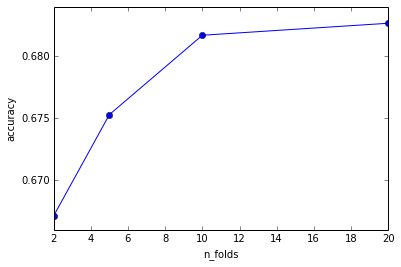

[0.66712204007285969,
 0.67529612756264246,
 0.6816977999169781,
 0.68266472060050032]

In [36]:
def compare_n_folds(filenames, y):
    """
    Vary the setting of n_folds parameter in the do_expt 
    function to be in [2,5,10,20]. For each setting, call do_expt and 
    store the resulting accuracy. Plot the accuracies for each setting.
    Also return the list of accuracies. Use the default value for all
    other arguments to the do_expt function.
    Params:
        filenames....list of training file names
        y............true labels for each file (a numpy array)
    Returns:
        a list of average testing accuracies, one per fold.
    """
    ###TODO
    ###
    fold_list = [2,5,10,20]
    
    result = [do_expt(filenames,y,n_folds = nf) for nf in fold_list]
    plt.plot(fold_list, result,'bo-')
    plt.xlabel('n_folds')
    plt.ylabel('accuracy')
    plt.show()
    return result    
    
compare_n_folds(filenames, y)

In [37]:
def compare_binary(filenames, y):
    """
    How does the binary parameter affect results? 
    Call do_expt twice, once with binary=True, and once with binary=False.
    Return the average accuracies for each. Use the default parameters for the
    remaining arguments in do_expt.
    Params:
        filenames....list of training file names
        y............true labels for each file (a numpy array)
    Returns:
        a list of average testing accuracies. The first entry
        is for binary=True, the second is for binary=False.
    """
    ###TODO
    ###
    accuracies=[]
    accuracies.append(do_expt(filenames,y,binary=True))
    accuracies.append(do_expt(filenames,y,binary=False))
    return accuracies
          
compare_binary(filenames, y)

[0.67529612756264246, 0.74177365914267956]

In [38]:
def tokenize_with_punct(text):
    """Given a string, return a list of tokens such that: (1) all
    tokens are lowercase, (2) all punctuation is kept as separate tokens.
    Note that underscore (_) is not considered punctuation.
    Params:
        text....a string
    Returns:
        a list of tokens
    """
    ###TODO
    ###
    
    text = re.sub(r'[\x85]'," ",text)
    return re.findall(r"[\w]+|[^\w\s]", text.lower())
   
    
tokenize_with_punct("Hi! How's it going??? an_underscore is not *really* punctuation.")

['hi',
 '!',
 'how',
 "'",
 's',
 'it',
 'going',
 '?',
 '?',
 '?',
 'an_underscore',
 'is',
 'not',
 '*',
 'really',
 '*',
 'punctuation',
 '.']

In [39]:
nonascii_string = u'not the fiancée of not Henri'
print nonascii_string
print('tokenize: %s' % 
      ', '.join(tokenize(nonascii_string)))
print('tokenize_with_punct: %s' %
      ', '.join(tokenize_with_punct(nonascii_string)))
print('tokenize_with_not: %s' %
      ', '.join(tokenize_with_not(nonascii_string)))

print tokenize_with_punct(u'hi there\n how are you?')
#[u'hi', u'there', u'how', u'are', u'you', u'?']

print tokenize_with_punct(u'hi there \x85 how are you?')
#[u'hi', u'there', u'how', u'are', u'you', u'?']

print tokenize_with_punct(u'hi there \r how are you?')
#[u'hi', u'there', u'how', u'are', u'you', u'?']

not the fiancée of not Henri
tokenize: not, the, fianc, e, of, not, henri
tokenize_with_punct: not, the, fianc, é, e, of, not, henri
tokenize_with_not: not, not_the, not_fianc, e, of, not, not_henri
[u'hi', u'there', u'how', u'are', u'you', u'?']
[u'hi', u'there', u'how', u'are', u'you', u'?']
[u'hi', u'there', u'how', u'are', u'you', u'?']


In [40]:
def tokenizer_expt(all_train_files, y):
    """
    How does the tokenizer affect results? 
    Call do_expt three times, using three different tokenizers:
    1- tokenize
    2- tokenize_with_punct
    3- tokenize_with_not
    Return the average cross-validation accuracy for each approach,
    in the above order. Use the default parameters for all other 
    arguments to do_expt.
    Params:
        filenames....list of training file names
        y............true labels for each file (a numpy array)
    Returns:
        a list of average testing accuracies for each tokenizer.
    """
    ###TODO
    ###      
    return [do_expt(filenames=all_train_files, y=y,tokenizer_fn = t) 
            for t in [tokenize,tokenize_with_punct,tokenize_with_not]]

tokenizer_expt(filenames, y)

[0.67529612756264246, 0.67529612756264246, 0.69852350383102091]

In [ ]:
##So among these tokenizers, we are getting maximum accuracy in tokenize_with_not. So we are going to use
## tokenize_with_not in every function from now. 

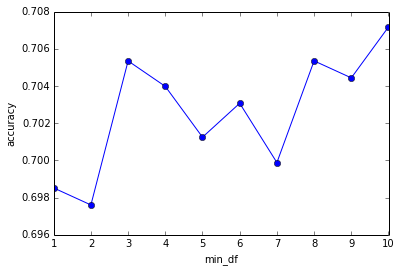

[0.69852350383102091,
 0.69761027127769726,
 0.70535307517084278,
 0.70398426175191553,
 0.70125284738041005,
 0.70307620625388267,
 0.6998892110167737,
 0.70535618140401735,
 0.70444191343963547,
 0.70717954027749008]

In [41]:
def min_df_expt(filenames, y):
    """
    Vary the setting of min_df parameter in the do_expt 
    function to be ints in the range (1,10) (inclusive). For each setting,
    call do_expt and store the resulting accuracy. Plot the accuracies for each setting.
    Also return the list of accuracies. Use the default value for all
    other arguments to the do_expt function, except that the tokenizer
    should be tokenize_with_not.
    Params:
        filenames....list of training file names
        y............true labels for each file (a numpy array)
    Returns:
        a list of average testing accuracies, one per min_df value.
    """
    ###TODO
    ###
    accuracy = [do_expt(filenames,y,tokenizer_fn = tokenize_with_not, min_df=i) for i in range(1,11)]
    plt.plot(range(1,11), accuracy,'bo-')
    plt.xlabel('min_df')
    plt.ylabel('accuracy')
    plt.show()
    return accuracy

min_df_expt(filenames, y)

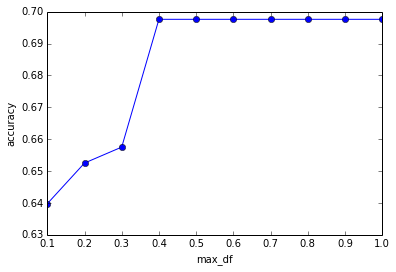

[0.63978981155518733,
 0.6525336508593913,
 0.65753986332574033,
 0.69761027127769726,
 0.69761027127769726,
 0.69761027127769726,
 0.69761027127769726,
 0.69761027127769726,
 0.69761027127769726,
 0.69761027127769726]

In [42]:
def max_df_expt(filenames, y):
    """
    Vary the setting of max_df parameter in the do_expt 
    function to be one of [.1, .2, .3, .4, .5, .6, .7, .8, .9, 1.].
    For each setting, call do_expt and store the resulting accuracy.
    Plot the accuracies for each setting. Also return the list of accuracies.
    Use the default value for all other arguments to the do_expt function,
    except that the tokenizer=tokenize_with_not and min_df=2.
    Params:
        filenames....list of training file names
        y............true labels for each file (a numpy array)
    Returns:
        a list of average testing accuracies, one per max_df value.
    """
    ###TODO
    ###
    max_dflist = [.1, .2, .3, .4, .5, .6, .7, .8, .9, 1.]
    accuracy = [do_expt(filenames, y, tokenizer_fn = tokenize_with_not, min_df = 2, max_df = i) 
                for i in max_dflist]
    plt.plot(max_dflist, accuracy,'bo-')
    plt.xlabel('max_df')
    plt.ylabel('accuracy')
    plt.show()
    return accuracy
    
max_df_expt(filenames, y)

In [43]:
# First, we'll train our final classifier using our best settings.
X, vec = do_vectorize(filenames, tokenizer_fn=tokenize_with_not,
                      binary=False, min_df=3, max_df=.4)
clf = get_clf_naive()
clf.fit(X, y)

MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)

In [44]:
print type(clf.coef_)
print clf.coef_.shape

<type 'numpy.ndarray'>
(1, 2954)


In [45]:
# Here are the first 10 coefficients.
print(clf.coef_[0][:10])
# The features corresponding to them can be found using the vectorizer's get_feature_names method.
print(vec.get_feature_names()[:10])

[ -7.66254205  -8.00841506  -5.73859224  -5.66454527  -7.66254205
 -10.40631033  -8.00841506  -8.00841506 -10.40631033  -7.92900828]
[u'0', u'00', u'1', u'10', u'100', u'1080', u'1080p', u'11', u'11ac', u'12']


In [46]:
from sklearn import metrics
predict_label = []
m = clf.predict_proba(X)
for pos, neg in m:
    if pos > neg:
        predict_label.append(1)
    else:
        predict_label.append(0)
print(metrics.classification_report(y,np.array(predict_label)))
print(metrics.confusion_matrix(y,np.array(predict_label)))

             precision    recall  f1-score   support

          0       0.24      0.30      0.26      1093
          1       0.05      0.04      0.04      1103

avg / total       0.14      0.17      0.15      2196

[[ 329  764]
 [1063   40]]


In [47]:
def get_top_coefficients(clf, vec, n=10):
    """ Get the top n coefficients for each class (positive/negative).
    Params:
        clf...a LogisticRegression object that has already been fit to data.
        vec...a CountVectorizer
        n.....the number of features to print per class.
    Returns:
        Two lists of tuples. The first list containts the top terms for the positive
        class. Each entry is a tuple of (string, float) pairs, where
        string is the feature name and float is the coefficient.
        The second list is the same but for the negative class.
        In each list, entries should be sorted in descending order of 
        absolute value."""
    ###TODO
    ###
    pos_coef = []
    neg_coef = []
    #iterating through all feature names and their assigned coeeficient value
    for i in zip(vec.get_feature_names(),clf.coef_[0]):
        #if coef is positive then append it to positive coefficient list 
        if i[1] > 0:
            pos_coef.append(i)
        #if coef is negative then append it to negative coefficient list 
        else:
            neg_coef.append(i)
    return sorted(pos_coef, key=lambda x:x[1], reverse=True)[:5], sorted(neg_coef, key=lambda x:x[1], reverse=False)[:5]

pos_coef, neg_coef = get_top_coefficients(clf, vec, n=5)
print('top positive coefs: %s' % str(pos_coef))
print('top negative coefs: %s' % str(neg_coef))

top positive coefs: []
top negative coefs: [(u'120', -12.804205602486388), (u'1366', -12.804205602486388), (u'144', -12.804205602486388), (u'149', -12.804205602486388), (u'21', -12.804205602486388)]


In [48]:
# Do not modify.
pos_test_files = get_files(path + os.sep + 'test' + os.sep + 'pos')
neg_test_files = get_files(path + os.sep + 'test' + os.sep + 'neg')
all_test_files = pos_test_files + neg_test_files
# Note that we call .transform, not .fit_transform, since we 
# don't want to learn a new vocabulary.
X_test = vec.transform(all_test_files)
y_test = np.array([1] * len(pos_test_files) + [0] * len(neg_test_files))
print('X_test represents %d documents with %d features' % (X_test.shape[0], X_test.shape[1]))
print('y_test has %d positive and %d negative labels' % (len(np.where(y_test==1)[0]),
                                                          len(np.where(y_test==0)[0])))
print('first testing file is %s' % all_test_files[0])
print('last testing file is %s' % all_test_files[-1])
print('testing accuracy=%.4g' % accuracy_score(y_test, clf.predict(X_test)))

X_test represents 550 documents with 2954 features
y_test has 219 positive and 331 negative labels
first testing file is Data/test/pos/r2196.txt
last testing file is Data/test/neg/r2745.txt
testing accuracy=0.6091


In [49]:
def get_top_errors(X_test, y_test, filenames, clf, n=10):
    """
    Use clf to predict the labels of the testing data in X_test. 
    We want to find incorrectly predicted documents. Furthermore, we want to look at those 
    where the probability of the incorrect label, according to the classifier, is highest.
    Use the .predict_proba method of the classifier to get the probabilities of
    each class label. Return the n documents that were misclassified, sorted by the
    probability of the incorrect label. The returned value is a list of dicts, defined below.
    Params:
        X_test......the testing matrix
        y_test......the true labels for each testing document
        filenames...the filenames for each testing document
        clf.........a trained LogisticRegression object
        n...........the number of errors to return
    Returns:
        A list of n dicts containing the following key/value pairs:
           index: the index of this document (in the filenames array)
           probas: a numpy array containing the probability of class 0 and 1
           truth: the true label
           predicted: the predicted label
           filename: the path to the file for this document
    """
    ###TODO
    ###
   
    
    lst = []
    newlist = []
    predicted = clf.predict(X_test)
    
    predicted_proba = clf.predict_proba(X_test)
    
    for i in range(len(predicted)):
        probability = predicted_proba[i][predicted[i]]
        d = {}
        dic = {}
        
        if predicted[i] != y_test[i]:
            
            if predicted[i] == 0:
                dic['index'] = i
                dic['probas'] = predicted_proba[i][0]
            else:
                dic['index'] = i
                dic['probas'] = predicted_proba[i][1]
            
            lst.append(dic)
    newlist = sorted(lst, key=itemgetter('probas'),reverse=True) 
    
    #print ls
    p = []            
    for i in newlist[:n]:
        p.append(i.values()[0])
           
    #print p
    ls = []
    for i in p:
        d={}
        d['filename'] = filenames[i]
        d['index'] = i
        d['predicted'] = predicted[i]
        d['probas'] = predicted_proba[i]
        d['truth'] = y_test[i]
    
        ls.append(d)
    
    
    return ls 
    
errors = get_top_errors(X_test, y_test, all_test_files, clf)
errors 

[{'filename': 'Data/test/pos/r2488.txt',
  'index': 130,
  'predicted': 0,
  'probas': array([  1.00000000e+00,   1.88060135e-13]),
  'truth': 1},
 {'filename': 'Data/test/pos/r2427.txt',
  'index': 104,
  'predicted': 0,
  'probas': array([  9.99810302e-01,   1.89697564e-04]),
  'truth': 1},
 {'filename': 'Data/test/neg/r2389.txt',
  'index': 324,
  'predicted': 1,
  'probas': array([  2.54300534e-04,   9.99745699e-01]),
  'truth': 0},
 {'filename': 'Data/test/pos/r2255.txt',
  'index': 35,
  'predicted': 0,
  'probas': array([ 0.99814817,  0.00185183]),
  'truth': 1},
 {'filename': 'Data/test/neg/r2476.txt',
  'index': 370,
  'predicted': 1,
  'probas': array([ 0.00311235,  0.99688765]),
  'truth': 0},
 {'filename': 'Data/test/neg/r2272.txt',
  'index': 252,
  'predicted': 1,
  'probas': array([ 0.0032878,  0.9967122]),
  'truth': 0},
 {'filename': 'Data/test/neg/r2633.txt',
  'index': 479,
  'predicted': 1,
  'probas': array([ 0.00539518,  0.99460482]),
  'truth': 0},
 {'filename': 

In [50]:
from sklearn import metrics
predict_label = []
m = clf.predict_proba(X)
for pos, neg in m:
    if pos > neg:
        predict_label.append(1)
    else:
        predict_label.append(0)
print(metrics.classification_report(y,np.array(predict_label)))
print(metrics.confusion_matrix(y,np.array(predict_label)))

             precision    recall  f1-score   support

          0       0.24      0.30      0.26      1093
          1       0.05      0.04      0.04      1103

avg / total       0.14      0.17      0.15      2196

[[ 329  764]
 [1063   40]]


In [51]:
# Given a document, find the term in it that is most strongly associated
# with a given class label, according to a trained classifier.
def most_predictive_term_in_doc(instance, clf, class_idx):
    """
    Params:
        instance....one row in the X csr_matrix, corresponding to a document.
        clf.........a trained LogisticRegression classifier
        class_idx...0 or 1. The class for which we should find the most 
                    predictive term in this document.
    Returns:
        The index corresponding to the term that appears in this instance
        and has the highest coefficient for class class_idx.
    """
    ###TODO
    ###
    
    lst = []
    lm = []
    newlist = []
    newlist1 = []
    
    for i in instance.nonzero()[1]:
        lst.append(i)
    
    for i in lst:
        clff = {}
        clff['index']=i
        clff['coef'] = (clf.coef_[0][i])
        lm.append(clff)
    
   
    newlist = sorted(lm, key=itemgetter('coef'),reverse=True) 
    
    newlist1 = sorted(lm, key=itemgetter('coef')) 
    
    if class_idx  == 1:
        return int(newlist[0]['index'])
    
    else:
        return int(newlist1[0]['index'] )
    
    
#most_predictive_term_in_doc(X_test[0], clf, 0)
neg_idx = most_predictive_term_in_doc(X_test[0], clf, 0)
pos_idx = most_predictive_term_in_doc(X_test[0], clf, 1)
print('for document %s, the term most predictive of class 0 is %s (index=%d)' %
      (all_test_files[0], vec.get_feature_names()[neg_idx], neg_idx))
print('for document %s, the term most predictive of class 1 is %s (index=%d)' %
      (all_test_files[0], vec.get_feature_names()[pos_idx], pos_idx))

for document Data/test/pos/r2196.txt, the term most predictive of class 0 is appear (index=224)
for document Data/test/pos/r2196.txt, the term most predictive of class 1 is use (index=2781)


In [ ]:
## Decision Tree Classifier
## http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html


In [52]:
from sklearn.tree import DecisionTreeClassifier

def get_clf_tree():
    return DecisionTreeClassifier(random_state=0)


In [53]:
def do_cross_validation(X, y, n_folds=5, verbose=False):
    """
    Perform n-fold cross validation, calling get_clf() to train n
    different classifiers. Use sklearn's KFold class: http://goo.gl/wmyFhi
    Be sure not to shuffle the data, otherwise your output will differ.
    Params:
        X.........a csr_matrix of feature vectors
        y.........the true labels of each document
        n_folds...the number of folds of cross-validation to do
        verbose...If true, report the testing accuracy for each fold.
    Return:
        the average testing accuracy across all folds.
    """
    ###TODO
    ###
    g = get_clf_tree()
    kf = cross_validation.KFold(len(y), n_folds=n_folds)
    accuracies = []
    
    for train_idx, test_idx in kf:    
        g.fit(X[train_idx], y[train_idx])
        #print len(train_idx)
        predicted = g.predict(X[test_idx])
        acc = accuracy_score(y[test_idx], predicted)
        if verbose:
            print "fold %d accuracy=%.4f"  %(len(accuracies),acc)
        accuracies.append(acc)
    avg = np.mean(accuracies)
    return avg

print('average cross validation accuracy=%.4f' %
      do_cross_validation(X, y, verbose=True))

fold 0 accuracy=0.7909
fold 1 accuracy=0.7950
fold 2 accuracy=0.7973
fold 3 accuracy=0.8087
fold 4 accuracy=0.8246
average cross validation accuracy=0.8033


In [54]:
def do_expt(filenames, y, tokenizer_fn=tokenize,
            min_df=1, max_df=1., binary=True,
            ngram_range=(1,1), n_folds=5):
    """
    Run one experiment, which consists of vectorizing each file,
    performing cross-validation, and returning the average accuracy.
    You should call do_vectorize and do_cross_validation here.
    Params:
        filenames.......list of review file names
        y...............the true sentiment labels for each file
        tokenizer_fn....the function used to tokenize each document
        min_df..........remove terms from the vocabulary that don't appear
                        in at least this many documents
        max_df..........remove terms from the vocabulary that appear in more
                        than this fraction of documents
        binary..........If true, each documents is represented by a binary
                        vector, where 1 means a term occurs at least once in 
                        the document. If false, the term frequency is used instead.
        ngram_range.....A tuple (n,m) means to use phrases of length n to m inclusive.
                        E.g., (1,2) means consider unigrams and bigrams.
        n_folds.........The number of cross-validation folds to use.
    Returns:
        the average cross validation testing accuracy.
    """
    ###TODO
    ###
    
    
    mat, vec = do_vectorize(filenames.tolist(),tokenizer_fn=tokenizer_fn,binary=binary,min_df=min_df,max_df=max_df,ngram_range=ngram_range)
    avg = do_cross_validation(mat, y,n_folds = n_folds)
    return avg


print('accuracy using default settings: %.4g' % do_expt(filenames, y))

accuracy using default settings: 0.8101


In [55]:
# First, we'll train our final classifier using our best settings.
X, vec = do_vectorize(filenames, tokenizer_fn=tokenize,
                      binary=True, min_df=4, max_df=.4)
clf = get_clf_tree()
clf.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=0, splitter='best')

In [56]:
from sklearn import metrics
predict_label = []
m = clf.predict_proba(X)
for pos, neg in m:
    if pos > neg:
        predict_label.append(1)
    else:
        predict_label.append(0)
print(metrics.classification_report(y,np.array(predict_label)))
print(metrics.confusion_matrix(y,np.array(predict_label)))

             precision    recall  f1-score   support

          0       0.00      0.00      0.00      1093
          1       0.00      0.00      0.00      1103

avg / total       0.00      0.00      0.00      2196

[[   3 1090]
 [1103    0]]
